## Notebook: Ptychography reconstruction with positions update from a CXI dataset

In [1]:
########################################################################
#
# (c) ESRF 2020-present
# Authors: Vincent Favre-Nicolin <favre@esrf.fr>
#
# This is a test notebook to look at pixel statistics from the LLK calculated
# on the series of frames.
#
########################################################################
import os
# Select language and/or GPU name or rank through environment variable (optional)
#os.environ['PYNX_PU'] = 'cuda.0'  

%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.signal import medfilt2d
from pynx.ptycho import simulation, shape
from pynx.utils.math import llk_poisson
import warnings
warnings.simplefilter('ignore')

# Import Ptycho, PtychoData and operators (automatically selecting OpenCL or CUDA)
from pynx.ptycho import *
from pynx.utils.plot_utils import complex2rgbalin

# Import CXI runner
from pynx.ptycho.runner.cxi import PtychoRunnerScanCXI
from pynx.ptycho.runner.runner import params_generic as params

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

/Users/vincent/dev/py36-env/lib/python3.6/site-packages/skcuda/cublas.py:284: UserWarning: creating CUBLAS context to get version number
  warnings.warn('creating CUBLAS context to get version number')


In [2]:
# Download CXI data if necessary
if not os.path.exists('ptycho-siemens-star-id01.cxi'):
    os.system('curl -O http://ftp.esrf.fr/pub/scisoft/PyNX/data/ptycho-siemens-star-id01.cxi')

In [3]:
##################
# Load CXI data
params['saveprefix']='ResultsScan%04d/Run%04d'

params['cxifile']='ptycho-siemens-star-id01.cxi'
#params['cxifile']='/Users/vincent/data/201606id01-FZP-S0013.cxi'
params['probe']='gauss,150e-9x200e-9'  # Starting from a simulated probe, here described as gaussian
params['defocus'] = 200e-6

params['object'] = 'random,0.8,1,0,0.5'
params['verbose'] = 10
params['algorithm'] = "manual"
params['maxframe'] = 512

# Make sure stack size is the same for OpenCL and CUDA
#params['stack_size'] = 16
#cuop.default_processing_unit.set_stack_size(16)
#clop.default_processing_unit.set_stack_size(16)

ws = PtychoRunnerScanCXI(params, 0)
ws.load_scan()
ws.load_data()  # Load all frames from a maxipix detector using CXI/HDF5 data
ws.prepare_processing_unit()

ws.center_crop_data()  # Auto-crop the data
ws.prepare()  # This will prepare the initial object

# Set stack size to the total number of frames
n = len(ws.x)
params['stack_size'] = min(128, len(ws.x))
default_processing_unit.set_stack_size(min(128, len(ws.x)))


MAXFRAME: only using first 512 frames
CXI: read scan number=13
Reading 512 frames from CXI-HDF5 file: 0.20.40.60.80.100.120.140.160.180.200.220.240.260.280.300.320.340.360.380.400.420.440.460.480.500
Time to read all frames:  2.4s [57.55 Mpixel/s]
Loaded mask from CXI data: /entry_1/instrument_1/detector_1/mask
Initialized mask with 6156 ( 2.312%) bad pixels
Ptycho runner: preparing processing unit
Computing FFT speed for available CUDA GPU[ranking by fft, fft_shape=(16, 400, 400)]:
                                         GeForce GTX 1080 Ti: 11263Mb , 655.45 Gflop/s
Searching available OpenCL GPU[ranking by fft, fft_shape=(16, 400, 400)]:
                                 GeForce GTX 1080 Ti [Apple]: 11264Mb [max alloc.: 2816Mb], 254.66 Gflop/s
Using CUDA GPU: GeForce GTX 1080 Ti
Using CUDA GPU=> setting large stack size (128) (override with stack_size=N)
Center of diffraction: X=206.66 Y=209.16
Largest prime number acceptable for FFT size: 7
Final iobs data size after cropping / cent

In [4]:
# Initial optimisation
ws.run()  
ws.run_algorithm('nbprobe=3')

# Get Ptycho object
p = ws.p

# Enable bilinear interpolation (lowers resolution, but smoother position update)
p._interpolation = True

# Keep copies of object and probe to restore later
obj = p.get_obj()
probe = p.get_probe()


 #################################################################################################### 
# 
# Scan:  13 Run: 1
#
 ####################################################################################################
Simulating object: random
Making obj: (692, 684) 696 688
Simulating probe: gauss
ScaleObjProbe: 1.3848977 425923.94 490.38335544449575 12280.754289052407 0.03993104515917294

 #################################################################################################### 
# 
#         Run: 1 , Algorithm: nbprobe=3
#
 ####################################################################################################

Total elapsed time for algorithms:     0.03s 

 #################################################################################################### 

Probe statistics at sample position:
  FWHM (peak intensity):   167.49nm(H) x  171.61nm(V)
  FW @20% intensity    :   255.33nm(H) x  261.31nm(V)
  FWHM (statistical)   :   167.22nm(H) x  171.28

<IPython.core.display.Javascript object>


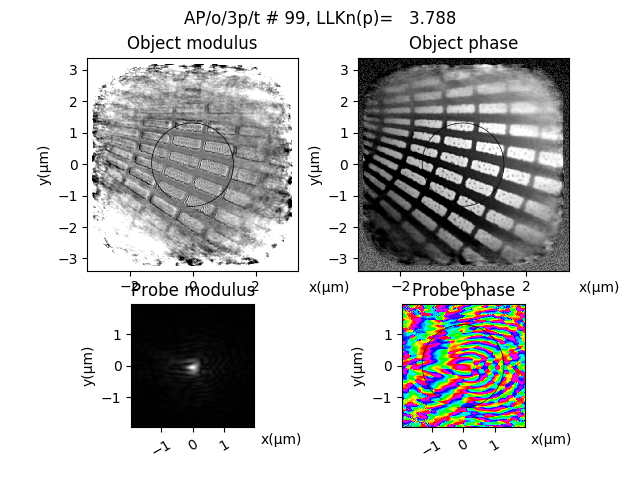

DM/o/3p    #  0 LLK=    51.85(p)   241.97(g)    92.49(e), nb photons=2.001356e+10, dt/cycle=0.000s
DM/o/3p    # 20 LLK=    14.90(p)    25.86(g)    23.33(e), nb photons=2.026484e+10, dt/cycle=0.214s
DM/o/3p    # 40 LLK=    16.79(p)    31.71(g)    26.31(e), nb photons=1.956034e+10, dt/cycle=0.210s
DM/o/3p    # 60 LLK=    17.12(p)    61.54(g)    27.50(e), nb photons=1.947248e+10, dt/cycle=0.208s
DM/o/3p    # 80 LLK=    15.19(p)    60.04(g)    24.36(e), nb photons=1.970595e+10, dt/cycle=0.208s
DM/o/3p    # 99 LLK=    16.97(p)    49.75(g)    27.15(e), nb photons=1.941832e+10, dt/cycle=0.209s
AP/o/3p/t  #100 LLK=    13.84(p)    59.84(g)    22.72(e), nb photons=2.261452e+10, dt/cycle=0.656s
AP/o/3p/t  #120 LLK=     4.83(p)    63.64(g)     9.49(e), nb photons=2.258036e+10, dt/cycle=0.200s
AP/o/3p/t  #140 LLK=     4.20(p)    61.95(g)     8.31(e), nb photons=2.247558e+10, dt/cycle=0.197s
AP/o/3p/t  #160 LLK=     3.98(p)    60.23(g)     7.90(e), nb photons=2.243427e+10, dt/cycle=0.197s
AP/o/3p/t 

In [5]:
plt.figure()
p = ShowObjProbe() * DM(update_object=True, update_probe=True, calc_llk=20, show_obj_probe=20)**100 * p
p = ShowObjProbe() * AP(update_object=True, update_probe=True, update_pos=True, calc_llk=20, show_obj_probe=20)**100 * p

#p = ShowObjProbe() * ML(update_object=True, update_probe=True, calc_llk=20, show_obj_probe=20)**100 * p

# Why is ML creating ring artefacts + some slit-scattering-like in the residual LLK ?

<IPython.core.display.Javascript object>


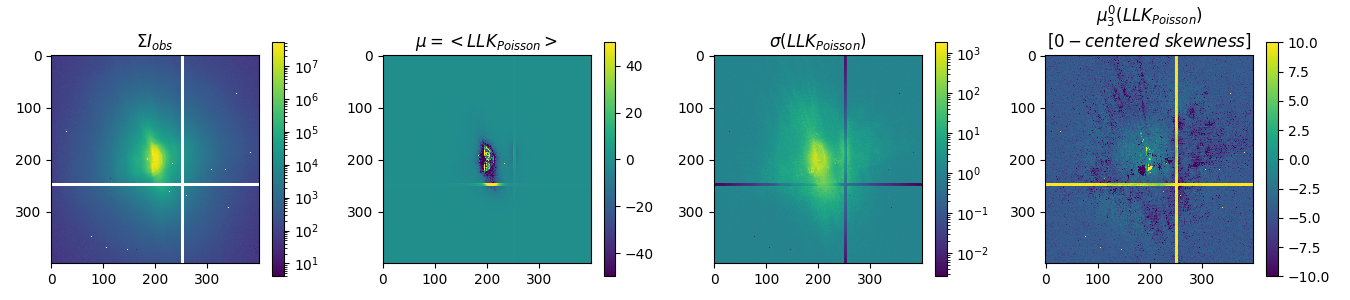

In [6]:
nbin = 100
binsize = 5
p = LLKPoissonStats(nbin=nbin, binsize=binsize) * p

plt.figure(figsize=(13.5,3))

plt.subplot(141)
plt.imshow(fftshift(p.data.iobs.sum(axis=0)),norm=LogNorm())
plt.title("$\Sigma I_{obs}$")
plt.colorbar()

plt.subplot(142)
plt.imshow(fftshift(p._llk_mean),vmin=-50,vmax=50)
plt.colorbar()
plt.title("$\mu=<LLK_{Poisson}>$")

plt.subplot(143)
plt.imshow(fftshift(p._llk_std),norm=LogNorm())
plt.colorbar()
plt.title("$\sigma(LLK_{Poisson})$")

plt.subplot(144)
# skew0 is the skewness computed with a mean set to 0, the expected average LLK
# skew is the normal skewness, centered on the actual pixel mean
plt.imshow(fftshift(p._llk_skew0),vmin=-10,vmax=10)
plt.colorbar()
plt.title("$\mu_3^0(LLK_{Poisson})$\n$[0-centered\ skewness]$")

plt.tight_layout()

<IPython.core.display.Javascript object>


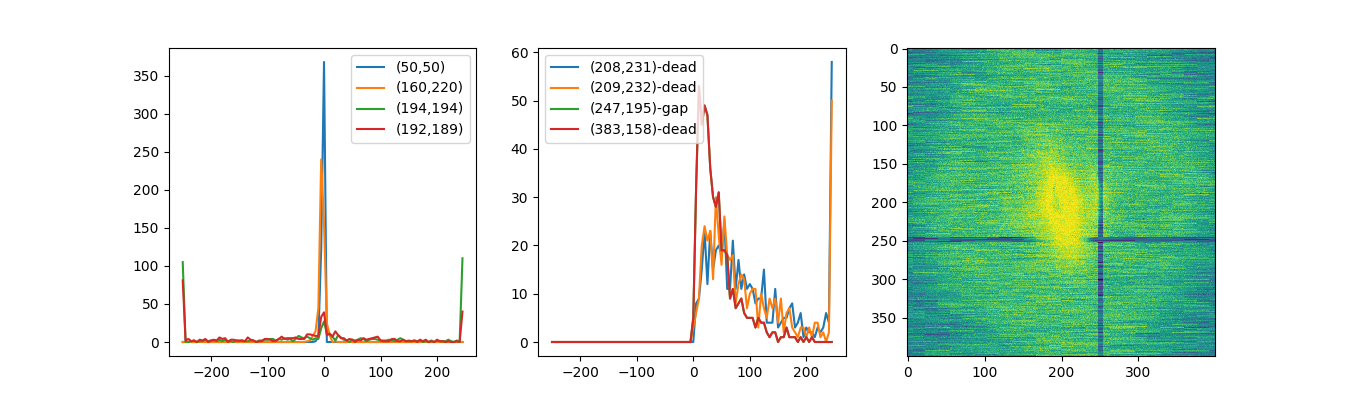

In [7]:
xhist = (np.arange(nbin) - nbin/2) * binsize 

plt.figure(figsize=(13.5,4))
llk_poisson_hist = fftshift(p._llk_poisson_hist, axes=(1,2))

plt.subplot(131)
plt.plot(xhist, llk_poisson_hist[:,50,50], label='(50,50)') # weak
plt.plot(xhist, llk_poisson_hist[:,160,220], label='(160,220)') # medium
plt.plot(xhist, llk_poisson_hist[:,194,194], label='(194,194)') # strong
plt.plot(xhist, llk_poisson_hist[:,192,189], label='(192,189)') # strong
plt.legend()
plt.subplot(132)
plt.plot(xhist, llk_poisson_hist[:,208,231], label='(208,231)-dead')
plt.plot(xhist, llk_poisson_hist[:,209,232], label='(209,232)-dead')
plt.plot(xhist, llk_poisson_hist[:,247,195], label='(247,195)-gap')
plt.plot(xhist, llk_poisson_hist[:,247,195], label='(383,158)-dead')
plt.legend()
plt.subplot(133)
plt.imshow(llk_poisson_hist.sum(axis=0))